<a href="https://colab.research.google.com/github/1992Taku0512/Signate_JT/blob/master/JT_tutorial_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#事前処理

ライブラリの読み込み

In [0]:
import pandas as pd
import os
import json

Googleドライブをマウント

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


作業ディレクトリの指定

In [0]:
cd /content/drive/My Drive/Document/Private/SIGNATE/JT

/content/drive/My Drive/Document/Private/SIGNATE/JT


#前処理

###銘柄データの確認

In [0]:
master = pd.read_csv('master.tsv', sep='\t')
master.head()

,category,brand,product
0,1016,ﾎｰﾌﾟ,ﾎｰﾌﾟ (10)
1,1018,ﾋﾟｰｽ,ﾋﾟｰｽ (20)
2,1020,ｾﾌﾞﾝｽﾀｰ,ｾﾌﾞﾝｽﾀｰ
3,1023,ﾒﾋﾞｳｽ,ﾒﾋﾞｳｽ
4,1027,ﾊｲﾗｲﾄ,ﾊｲﾗｲﾄ


In [0]:
unique_id =master['category'].unique()
unique_brand = master['brand'].unique()

In [0]:
print('category total:', len(unique_id))
print('brand total:', len(unique_brand))

category total: 223
brand total: 22


###アノテーションデータの確認

In [0]:
annotations = os.listdir('train_annotations')
#annotations

In [0]:
category_data = {}
for annotation in annotations:
    with open(os.path.join('train_annotations', annotation)) as f:
        data = json.load(f)
    labels = data['labels']
    for label in labels:
        category = label['category']
        if category not in category_data:
            category_data[category] = {'num':0, 'acc_area':0}
        category_data[category]['num'] += 1
        category_data[category]['acc_area'] += (label['box2d']['x2']-label['box2d']['x1'])*(label['box2d']['y2']-label['box2d']['y1'])

In [0]:
category_df = pd.DataFrame(category_data).T
category_df['area_mean'] = category_df['acc_area']/category_df['num']
category_df[['num', 'area_mean']].describe()

,num,area_mean
count,223.000000,223.000000
mean,106.493274,21290.272024
std,34.153584,3002.621947
min,35.000000,13201.385246
25%,71.000000,19709.595008
50%,120.000000,21229.973684
75%,126.000000,23428.325591
max,207.000000,27332.296875


In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

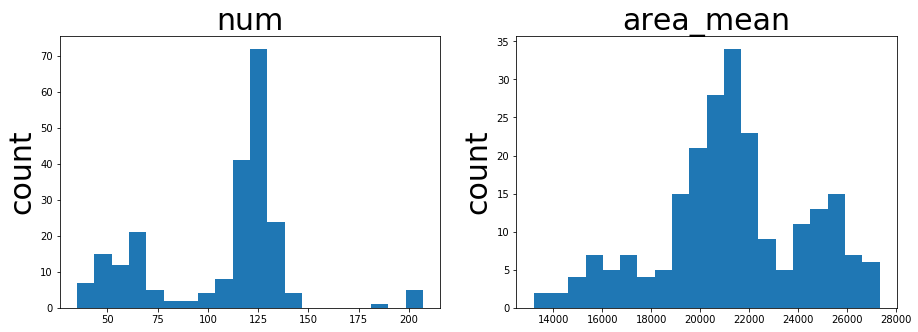

In [0]:
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(15,5))
modes = ['num','area_mean']
for i,mode in enumerate(modes):
    axes[i].hist(list(category_df[mode]), 20)
    axes[i].set_title(mode, fontsize=30)
    axes[i].set_ylabel('count', fontsize=30)

In [0]:
category_df = category_df.reset_index()[['index', 'num', 'area_mean']]
category_df.columns = ['category', 'num', 'area_mean']
master = pd.merge(master, category_df)

In [0]:
summary_master = master.groupby('brand')[['num']].apply(sum).sort_values('num', ascending=False)
print('total:', summary_master['num'].sum())

total: 23748


###画像データの可視化

chainercvのインストール

In [0]:
! pip install chainercv

    100% |████████████████████████████████| 245kB 7.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/48/34/47/ace83b5217d8cd49bd017951c776588fd4a7d8a1bf8817141a
Successfully built chainercv


In [0]:
import numpy as np
import chainer
from PIL import Image
from chainercv.chainer_experimental.datasets.sliceable import GetterDataset
from chainercv.utils import read_image
from chainercv.visualizations import vis_bbox
from pylab import rcParams

rcParams['figure.figsize'] = 12,12
plt.rcParams['font.family'] = 'IPAPGothic' 

In [0]:
class BboxDataset(GetterDataset):
    def __init__(self, img_dir, annotation_dir, categories, img_ext='.jpg', annotation_ext='.json'):
        super(BboxDataset, self).__init__()
        
        self.names = [i.split('.')[0] for i in os.listdir(img_dir)]
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.categories = categories
        self.img_ext = img_ext
        self.annotation_ext = annotation_ext
        self.add_getter('img', self.get_image)
        self.add_getter(('bbox', 'label'), self.get_annotation)
    
    def __len__(self):
        return len(self.names)
    
    def get_image(self, i):
        name = self.names[i]
        img_path = os.path.join(self.img_dir, name+self.img_ext)
        img = read_image(img_path, color=True)
        
        return img
    
    def get_annotation(self, i):
        name = self.names[i]
        annotation_path = os.path.join(self.annotation_dir, name+self.annotation_ext)
        with open(annotation_path) as f:
            annotation = json.load(f)
        bbox = []
        label = []
        
        for l in annotation['labels']:
            category = str(l['category'])
            if category in self.categories:
                bb = l['box2d']
                bbox.append([bb['y1'], bb['x1'], bb['y2'], bb['x2']])
                label.append(self.categories.index(category))
                
        bbox = np.array(bbox).astype(np.float32)
        label = np.array(label).astype(np.int32)
        
        return bbox, label

In [0]:
categories = [str(i) for i in master['category']]

In [0]:
data = BboxDataset('train_images', 'train_annotations', categories)

In [0]:
index_num = 20
print(data.names[index_num])
img, bbox, label = data[index_num]

train_020


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


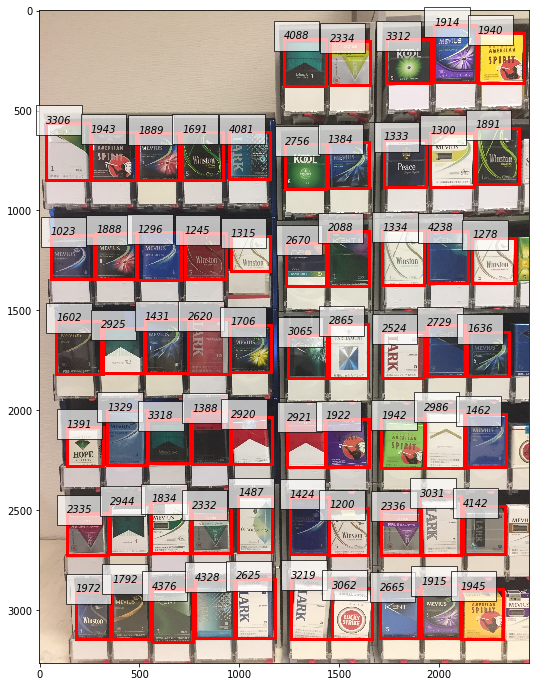

In [0]:
vis_bbox(img, bbox, label, label_names=categories)
plt.show()

In [0]:
brands = list(master['brand'])

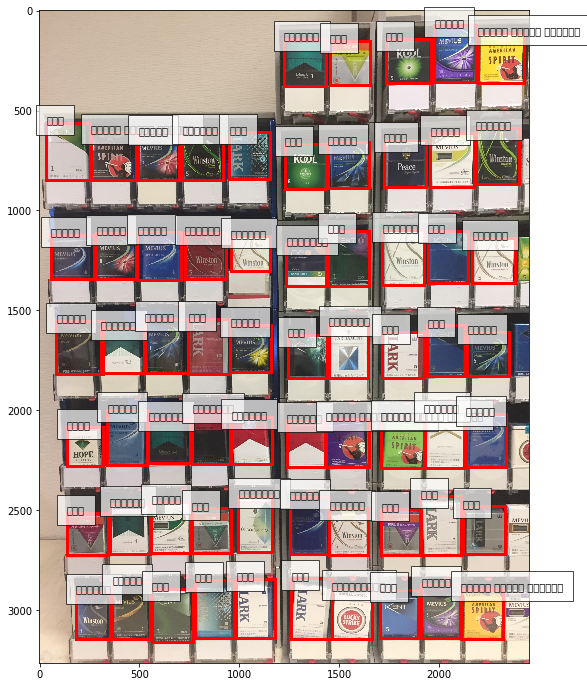

In [0]:
vis_bbox(img, bbox, label, label_names=brands)
plt.show()

In [0]:
brand = master.loc[set(master[master['brand']=='ﾋﾟｱﾆｯｼﾓ'].index).intersection(set(label))]
brand

,category,brand,product,num,area_mean
42,1388,ﾋﾟｱﾆｯｼﾓ,ﾋﾟｱﾆｯｼﾓ･ｱｲｼｰﾝ･ｸﾘｽﾀ･ﾒﾝｿｰﾙ,136,25683.279412
59,1487,ﾋﾟｱﾆｯｼﾓ,ﾋﾟｱﾆｯｼﾓ･ｱﾘｱ･ﾒﾝｿｰﾙ,122,24329.975410


In [0]:
imgs = []
for l,b in zip(label, bbox):
    if l in brand.index:
        imgs.append((brand.at[l, 'category'], img[:,int(b[0]):int(b[2])+1,int(b[1]):int(b[3])+1].transpose(1,2,0).astype(np.uint8)))

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


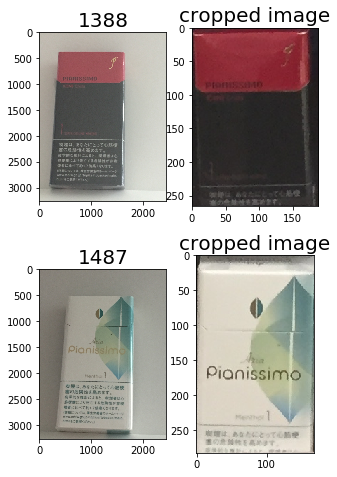

In [0]:
fig, axes = plt.subplots(nrows = len(imgs), ncols=2, figsize=(5,4*(len(imgs))))
for i,image in enumerate(imgs):
    master_image = read_image(os.path.join('master_images', str(image[0])+'.jpg')).transpose((1,2,0)).astype(np.uint8)
    axes[i,0].imshow(master_image)
    axes[i,0].set_title('{}'.format(image[0]), fontsize=20)

    axes[i,1].imshow(image[1])
    axes[i,1].set_title('cropped image', fontsize=20)

#モデリング

##領域検出

###深層学習のインスタンス化
一般的なたばこの検出を行うため, 全ての銘柄は同じクラスとして扱います.
深層学習モデルはSSD300[1]を用います.

In [0]:
from chainercv.links.model.ssd import multibox_loss
from chainercv.links import SSD300

In [0]:
class MultiboxTrainChain(chainer.Chain):
    def __init__(self, model, alpha=1, k=3):
        super(MultiboxTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.alpha = alpha
        self.k = k

    def __call__(self, imgs, gt_mb_locs, gt_mb_labels):
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = multibox_loss(
            mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss

        chainer.reporter.report(
            {'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss},
            self)

        return loss

In [0]:
eval_categories = ('tabacco',)

In [0]:
model_detector = SSD300(n_fg_class=len(eval_categories), pretrained_model = 'imagenet')

From: https://chainercv-models.preferred.jp/ssd_vgg16_imagenet_converted_2017_06_09.npz
To: /root/.chainer/dataset/_dl_cache/b4130ae0aa259c095b50ff95d81c32ee
  %   Total    Recv       Speed  Time left
100   76MiB   76MiB   4154KiB/s    0:00:00

In [0]:
model_detector.nms_thresh = 0.5
model_detector.score_thresh = 0.5
detector_train_chain = MultiboxTrainChain(model_detector)

###入力データ作成
適当なストライドのスライディングウィンドウにより, 適当な大きさの画像を切り取って改めて学習データを作成します.

In [0]:
import copy
from chainer.datasets import TransformDataset
from chainercv import transforms
from chainercv.links.model.ssd import random_crop_with_bbox_constraints
from chainercv.links.model.ssd import random_distort
from chainercv.links.model.ssd import resize_with_random_interpolation

In [0]:
class Transform():
    def __init__(self, coder, size, mean):
        # to send cpu, make a copy
        self.coder = copy.copy(coder)
        self.coder.to_cpu()

        self.size = size
        self.mean = mean

    def __call__(self, in_data):
        img, bbox, label = in_data

        # 1. Color augmentation
        img = random_distort(img)

        # 2. Random expansion
        if np.random.randint(2):
            img, param = transforms.random_expand(
                img, fill=self.mean, return_param=True)
            bbox = transforms.translate_bbox(
                bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

        # 3. Random cropping
        img, param = random_crop_with_bbox_constraints(
            img, bbox, return_param=True)
        bbox, param = transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        label = label[param['index']]

        # 4. Resizing with random interpolatation
        _, H, W = img.shape
        img = resize_with_random_interpolation(img, (self.size, self.size))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # 5. Random horizontal flipping
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (self.size, self.size), x_flip=params['x_flip'])

        # Preparation for SSD network
        img -= self.mean
        mb_loc, mb_label = self.coder.encode(bbox, label)

        return img, mb_loc, mb_label

In [0]:
os.makedirs('train_images_0', exist_ok=True)
os.makedirs('train_annotations_0', exist_ok=True)
os.makedirs('val_images', exist_ok=True)
os.makedirs('val_annotations', exist_ok=True)

In [0]:
def crop_image(src_img_dir, img_fname, src_annotation_dir, annotation_fname, dst_img_dir, dst_annotation_dir, stride=300, crop_size=600, buffer=30):
    image = Image.open(os.path.join(src_img_dir, img_fname))
    image_array = np.array(image)
    with open(os.path.join(src_annotation_dir, annotation_fname)) as f:
        annotation = json.load(f)
    bboxes = pd.DataFrame([bb['box2d'] for bb in annotation['labels']])
    count = 0
    for i in range(0,image_array.shape[0],stride):
        for j in range(0, image_array.shape[1],stride):
            inside = bboxes[(bboxes['x1']>=j-buffer)&(bboxes['y1']>=i-buffer)&(bboxes['x2']<=j+crop_size+buffer)&(bboxes['y2']<=i+crop_size+buffer)]
            if len(inside)>0:
                cropped_image = image_array[i:i+crop_size,j:j+crop_size,:]
                cropped_annotation={}
                cropped_annotation['labels'] = [{'box2d':{'x1':int(r['x1'])-j,
                                                          'y1':int(r['y1'])-i,
                                                          'x2':int(r['x2'])-j,
                                                          'y2':int(r['y2'])-i},
                                                 'category': 'tabacco'} for r in inside.to_dict('record')]
                img_name = img_fname.split('.')[0]+'_'+str(count)+'.jpg'
                annotation_name = annotation_fname.split('.')[0]+'_'+str(count)+'.json'
                Image.fromarray(cropped_image).save(os.path.join(dst_img_dir, img_name))
                with open(os.path.join(dst_annotation_dir, annotation_name), 'w') as f:
                    json.dump(cropped_annotation,f)
                count += 1

In [0]:
"""
count = 0
for train_images_file in os.listdir('train_images'):
    annotation_file_name =  os.path.splitext(train_images_file)[0]+'.json'
    if count < 175:
        crop_image('train_images', train_images_file, 'train_annotations', annotation_file_name, 'train_images_0', 'train_annotations_0')
    else:
        crop_image('train_images', train_images_file, 'train_annotations', annotation_file_name, 'val_images', 'val_annotations')
    count+=1
"""

"\ncount = 0\nfor train_images_file in os.listdir('train_images'):\n    annotation_file_name =  os.path.splitext(train_images_file)[0]+'.json'\n    if count < 175:\n        crop_image('train_images', train_images_file, 'train_annotations', annotation_file_name, 'train_images_0', 'train_annotations_0')\n    else:\n        crop_image('train_images', train_images_file, 'train_annotations', annotation_file_name, 'val_images', 'val_annotations')\n    count+=1\n"

In [0]:
train_data = BboxDataset('train_images_0', 'train_annotations_0', eval_categories)
val_data = BboxDataset('val_images', 'val_annotations', eval_categories)

In [0]:
transformed_train_data = TransformDataset(train_data, Transform(model_detector.coder, model_detector.insize, model_detector.mean))

###深層学習モデルの学習
上記で作成した学習データにより, SSD300モデルの学習を行います.

In [0]:
from chainer.optimizer_hooks import WeightDecay
from chainercv.links.model.ssd import GradientScaling
from chainer import training
from chainer.training import extensions, triggers
from chainercv.extensions import DetectionVOCEvaluator

ミニバッチサイズはbachsizeで, エポック数はnum_epochsとなります. 適宜変えてみてください.

In [0]:
gpu = 1
batchsize = 20
num_epochs = 5
train_iter = chainer.iterators.SerialIterator(transformed_train_data, batchsize)
val_iter = chainer.iterators.SerialIterator(val_data, batchsize, repeat=False, shuffle=False)
if gpu:
    gpu_id = 0
    model_detector.to_gpu()
else:
    gpu_id = -1
optimizer = chainer.optimizers.MomentumSGD(lr=0.0005)
optimizer.setup(detector_train_chain)

for param in detector_train_chain.params():
    if param.name == 'b':
        param.update_rule.add_hook(GradientScaling(2))
    else:
        param.update_rule.add_hook(WeightDecay(0.0001))

updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)
trainer = training.Trainer(updater, (num_epochs, 'epoch'), 'detection_results')

log_interval = 100, 'iteration'
trainer.extend(DetectionVOCEvaluator(val_iter, model_detector, use_07_metric=False,label_names=eval_categories),trigger=log_interval)
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'lr','main/loss', 'main/loss/loc', 'main/loss/conf','validation/main/map','elapsed_time']), trigger=log_interval)
trainer.extend(extensions.snapshot_object(model_detector, 'model_epoch_{.updater.epoch}'), trigger=(1, 'epoch'))

In [0]:
#trainer.run()

###深層学習モデルによる予測
棚画像データに対してたばこのパッケージの位置を上記で学習した深層学習モデルにより予測してみます.

In [0]:
from chainercv.utils.bbox.non_maximum_suppression import non_maximum_suppression

In [0]:
def detect_tabacco(model, img_dir, fname, stride = 300, crop_size=600):
    img = read_image(os.path.join(img_dir, fname))
    B = []
    L = []
    S = []
    for i in range(0,img.shape[1], stride):
        for j in range(0,img.shape[2], stride):
            img_cropped = img[:,i:i+crop_size,j:j+crop_size]
            bboxes, labels, scores = model.predict([img_cropped])
            B.append(bboxes[0]+[i,j,i,j])
            L.append(labels[0])
            S.append(scores[0])
    B = np.concatenate(B)
    L = np.concatenate(L)
    S = np.concatenate(S)
    r = non_maximum_suppression(bbox = B, thresh = 0.1,score = S)
    
    return B[r], L[r], S[r]

学習した深層学習モデルを読み込みます.

In [0]:
chainer.serializers.load_npz(os.path.join('detection_results', 'model_epoch_{}'.format(5)), model_detector)

評価用データの'test_015.jpg'に対して予測を行います.

In [0]:
test_img_dir = 'test_images_1'
fname = 'test_003.jpg'

In [0]:
bboxes, labels, scores = detect_tabacco(model_detector, test_img_dir, fname)

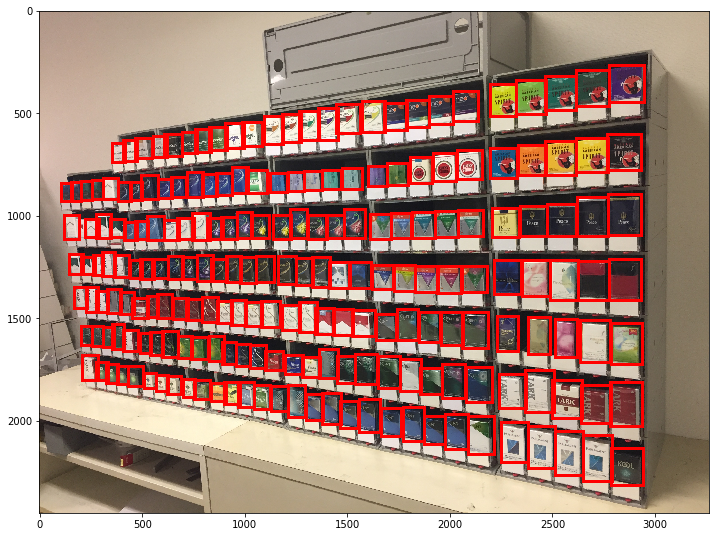

In [0]:
img = read_image(os.path.join(test_img_dir, fname))
#vis_bbox(img, bboxes, labels, scores, label_names=eval_categories)
vis_bbox(img, bboxes)

plt.show()

パッケージの検出はそれなりにできる。

##同一判別

###深層学習モデルのインスタンス化
2つの画像データ(マスター画像データと棚画像データにおいて領域検出されたデータ)を渡してそれらの類似度(または距離)を出力する深層学習モデルを構築します. ここではSiameseNetwork[2]を用います. contrasitive lossにより学習するパターンとtriplet lossにより学習するパターンを試みます.

In [0]:
import chainer.links as L
import chainer.functions as F

In [0]:
class FCN(chainer.Chain):
    def __init__(self):
        super(FCN, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 32, 3, stride=1)
            self.bn1 = L.BatchNormalization(32)
            self.conv2 = L.Convolution2D(None, 32, 3, stride=1)
            self.bn2 = L.BatchNormalization(32)
            self.conv3 = L.Convolution2D(None, 64, 3, stride=1)
            self.bn3 = L.BatchNormalization(64)
            self.conv4 = L.Convolution2D(None, 64, 3, stride=1)
            self.bn4 = L.BatchNormalization(64)
            self.conv5 = L.Convolution2D(None, 128, 3, stride=1)
            self.bn5 = L.BatchNormalization(128)
            self.conv6 = L.Convolution2D(None, 128, 3, stride=1)
            self.bn6 = L.BatchNormalization(128)
            self.conv7 = L.Convolution2D(None, 256, 3, stride=1)
            self.bn7 = L.BatchNormalization(256)
            self.conv8 = L.Convolution2D(None, 256, 3, stride=1)
            self.bn8 = L.BatchNormalization(256)
            self.conv9 = L.Convolution2D(None, 512, 3, stride=1)
            self.bn9 = L.BatchNormalization(512)
        
    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.max_pooling_2d(h, 2, stride=2)
        h = F.dropout(h, ratio=0.25)
        h = F.relu(self.bn3(self.conv3(h)))
        h = F.relu(self.bn4(self.conv4(h)))
        h = F.max_pooling_2d(h, 2, stride=2)
        h = F.dropout(h, ratio=0.25)
        h = F.relu(self.bn5(self.conv5(h)))
        h = F.relu(self.bn6(self.conv6(h)))
        h = F.max_pooling_2d(h, 2, stride=2)
        h = F.dropout(h, ratio=0.25)
        h = F.relu(self.bn7(self.conv7(h)))
        h = F.relu(self.bn8(self.conv8(h)))
        h = F.max_pooling_2d(h, 2, stride=2)
        h = F.dropout(h, ratio=0.25)
        h = F.relu(self.bn9(self.conv9(h)))
        h = F.average_pooling_2d(h, h.data.shape[2:], stride=1)
        y = F.reshape(h, h.data.shape[:2])
        
        return y

In [0]:
class SiameseTrainChain(chainer.Chain):
    def __init__(self, model, train):
        super(SiameseTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.train = train

    def __call__(self, imgs_0, labels_0, imgs_1, labels_1):
        with chainer.using_config('enable_backprop', self.train):
            with chainer.using_config('train', self.train):
                y_0 = self.model(imgs_0)
                y_1 = self.model(imgs_1)
                labels = (labels_0 == labels_1).astype(np.int32)
                loss = F.contrastive(y_0, y_1, labels)

        chainer.reporter.report({'loss': loss}, self)

        return loss

class TripletTrainChain(chainer.Chain):
    def __init__(self, model, train):
        super(TripletTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.train = train

    def __call__(self, imgs_0, imgs_1, imgs_2):
        with chainer.using_config('enable_backprop', self.train):
            with chainer.using_config('train', self.train):
                y_0 = self.model(imgs_0)
                y_1 = self.model(imgs_1)
                y_2 = self.model(imgs_2)
                loss = F.triplet(y_0, y_1, y_2)

        chainer.reporter.report({'loss': loss}, self)

        return loss

In [0]:
fcn_siamese = FCN()
fcn_triplet = FCN()

contrastive lossによる学習モデルを構築します.

In [0]:
siamese_train_chain = SiameseTrainChain(fcn_siamese, train=True)
siamese_val_chain = SiameseTrainChain(fcn_siamese, train=False)

triplet lossによる学習モデルを構築します.

In [0]:
triplet_train_chain = TripletTrainChain(fcn_triplet, train=True)
triplet_val_chain = TripletTrainChain(fcn_triplet, train=False)

###入力用データ作成
棚画像データに対してパッケージ部分を切り出し, カテゴリ別にその切り出された画像データを格納していきます.
マスター画像データに対して上記で学習した領域検出モデルによってパッケージ部分を切り出して同様にカテゴリ別に画像データを格納していきます.

In [0]:
import os
import numpy as np
import json
from PIL import Image

In [0]:
_train_annotations_path = 'train_annotations'
_train_images_path = 'train_images'
_master_images_path = 'master_images'

In [0]:
_train_images_1_path = 'train_images_1'
_val_images_1_path = 'val_images_1'
_train_images_2_path = 'train_images_2'

In [0]:
#import shutil

#shutil.rmtree(_train_images_1_path + "/")
#shutil.rmtree(_val_images_1_path + "/")
#shutil.rmtree(_train_images_2_path + "/")

In [0]:
#os.makedirs(_train_images_1_path, exist_ok=True)
#os.makedirs(_val_images_1_path, exist_ok=True)
#os.makedirs(_train_images_2_path, exist_ok=True)

In [0]:
"""
counts = {}
for img_name in os.listdir(_train_images_path):
    print(img_name)
    ann_name = img_name.split('.')[0]+'.json'
    with open(os.path.join(_train_annotations_path, ann_name)) as f:
        ann = json.load(f)
    img = Image.open(os.path.join(_train_images_path, img_name))
    for l in ann['labels']:
        t = np.random.binomial(1,0.9)
        box2d = l['box2d']
        category = l['category']
        if (32 <= box2d['x2'] - box2d['x1']) and (32 <= box2d['y2'] - box2d['y1']):
            cropped_img = img.crop((box2d['x1'],box2d['y1'],box2d['x2'],box2d['y2']))
            if t:
                if not os.path.exists(os.path.join(_train_images_1_path, str(category))):
                    os.mkdir(os.path.join(_train_images_1_path, str(category)))
                    counts[category] = 0
                cropped_img.save(os.path.join(_train_images_1_path, str(category), img_name.split('.')[0]+'_'+str(counts[category])+'.jpg'))
            else:
                if not os.path.exists(os.path.join(_val_images_1_path, str(category))):
                    os.mkdir(os.path.join(_val_images_1_path, str(category)))
                    counts[category] = 0
                cropped_img.save(os.path.join(_val_images_1_path, str(category), img_name.split('.')[0]+'_'+str(counts[category])+'.jpg'))                
            counts[category]+=1
        else:
            print('invalid bb')
"""

"\ncounts = {}\nfor img_name in os.listdir(_train_images_path):\n    print(img_name)\n    ann_name = img_name.split('.')[0]+'.json'\n    with open(os.path.join(_train_annotations_path, ann_name)) as f:\n        ann = json.load(f)\n    img = Image.open(os.path.join(_train_images_path, img_name))\n    for l in ann['labels']:\n        t = np.random.binomial(1,0.9)\n        box2d = l['box2d']\n        category = l['category']\n        if (32 <= box2d['x2'] - box2d['x1']) and (32 <= box2d['y2'] - box2d['y1']):\n            cropped_img = img.crop((box2d['x1'],box2d['y1'],box2d['x2'],box2d['y2']))\n            if t:\n                if not os.path.exists(os.path.join(_train_images_1_path, str(category))):\n                    os.mkdir(os.path.join(_train_images_1_path, str(category)))\n                    counts[category] = 0\n                cropped_img.save(os.path.join(_train_images_1_path, str(category), img_name.split('.')[0]+'_'+str(counts[category])+'.jpg'))\n            else:\n       

In [0]:
eval_categories = ('tabacco',)

In [0]:
gpu = 1
model_detector = SSD300(n_fg_class=len(eval_categories), pretrained_model = 'imagenet')
model_detector.score_thresh = 0.4
chainer.serializers.load_npz(os.path.join('detection_results', 'model_epoch_{}'.format(5)), model_detector)
if gpu:
    model_detector.to_gpu()

In [0]:
#glob.glob(_train_images_2_path+"/*")


In [0]:
"""
for master_img_path in os.listdir(_master_images_path):
    print(master_img_path)
    category = master_img_path.split('.')[0]
    master_img = read_image(os.path.join(_master_images_path, master_img_path))
    bbox, _, _ = model_detector.predict([master_img])
    if len(bbox[0]):
        y1, x1, y2, x2 = bbox[0][0]
        y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
        h = y2-y1
        w = x2-x1

        cropped_img = Image.fromarray(master_img[:,max(y1-100,0):max(y1-100,0)+int(h*0.7),max(x1-100,0):max(x1-100,0)+w+100].transpose((1,2,0)).astype(np.uint8))
        if not os.path.exists(os.path.join(_train_images_2_path, category)):
            os.mkdir(os.path.join(_train_images_2_path, category))
        cropped_img.save(os.path.join(_train_images_2_path, category, 'train_0.jpg'))
    else:
        print('undetected')
        if not os.path.exists(os.path.join(_train_images_2_path, category)):
            os.mkdir(os.path.join(_train_images_2_path, category))
        Image.fromarray(master_img.transpose((1,2,0)).astype(np.uint8)).save(os.path.join(_train_images_2_path, category, 'train_0.jpg'))
"""

"\nfor master_img_path in os.listdir(_master_images_path):\n    print(master_img_path)\n    category = master_img_path.split('.')[0]\n    master_img = read_image(os.path.join(_master_images_path, master_img_path))\n    bbox, _, _ = model_detector.predict([master_img])\n    if len(bbox[0]):\n        y1, x1, y2, x2 = bbox[0][0]\n        y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)\n        h = y2-y1\n        w = x2-x1\n\n        cropped_img = Image.fromarray(master_img[:,max(y1-100,0):max(y1-100,0)+int(h*0.7),max(x1-100,0):max(x1-100,0)+w+100].transpose((1,2,0)).astype(np.uint8))\n        if not os.path.exists(os.path.join(_train_images_2_path, category)):\n            os.mkdir(os.path.join(_train_images_2_path, category))\n        cropped_img.save(os.path.join(_train_images_2_path, category, 'train_0.jpg'))\n    else:\n        print('undetected')\n        if not os.path.exists(os.path.join(_train_images_2_path, category)):\n            os.mkdir(os.path.join(_train_images_2_path, 

In [0]:
from chainercv.datasets import DirectoryParsingLabelDataset, SiameseDataset, TransformDataset, directory_parsing_label_names
from chainercv import transforms

In [0]:
class Transform():
    def __init__(self, size, train):
        self.size = size
        self.train = train

    def __call__(self, in_data):
        img, label = in_data
        
        if self.train:
            # Color augmentation
            img = transforms.pca_lighting(img, 25.5)

            # Random sized crop
            img = transforms.random_sized_crop(img)

            # Random horizontal flipping
            img = transforms.random_flip(img, x_random=True)
        
        # Resize
        img = transforms.resize(img, (self.size, self.size))

        return img, label

In [0]:
class TripletDataset(GetterDataset):
    def __init__(self, anchor_dir, ref_dir):
        super(TripletDataset, self).__init__()
        self.anchor_dataset = DirectoryParsingLabelDataset(anchor_dir)
        self.ref_dataset = DirectoryParsingLabelDataset(ref_dir)
        self.anchor_label_names = np.array(directory_parsing_label_names(anchor_dir))
        self.ref_label_names = np.array(directory_parsing_label_names(ref_dir))
        self.ref_label_dist = {label_name: list(np.where(self.ref_dataset.labels==i)[0]) for i, label_name in enumerate(self.ref_label_names)}
        self.add_getter(('anchor', 'positive', 'negative'), self.get_data)
    
        
    def __len__(self):
        return len(self.anchor_dataset)
    
    def enable_transform(self, transform_function):
        self.anchor_dataset = TransformDataset(self.anchor_dataset, transform_function)
        self.ref_dataset = TransformDataset(self.ref_dataset, transform_function)

    def get_data(self, i):
        anchor, anchor_label = self.anchor_dataset[i]
        anchor_label_name = self.anchor_label_names[int(anchor_label)]

        # get positive sample from ref
        ref_label_positive_idx = np.random.choice(self.ref_label_dist[anchor_label_name])
        positive, positive_label = self.ref_dataset[ref_label_positive_idx]

        # get negative sample from ref
        ref_label_name_negative = np.random.choice(self.ref_label_names[np.where(self.ref_label_names != anchor_label_name)])
        ref_label_negative_idx = np.random.choice(self.ref_label_dist[ref_label_name_negative])
        negative, negative_label = self.ref_dataset[ref_label_negative_idx]
        
        return anchor, positive, negative

In [0]:
dataset_1 = DirectoryParsingLabelDataset(_train_images_1_path)
dataset_2 = DirectoryParsingLabelDataset(_train_images_2_path)
dataset_3 = DirectoryParsingLabelDataset(_val_images_1_path)
transformed_train_dataset_1 = TransformDataset(dataset_1, Transform(128, 1))
transformed_train_dataset_2 = TransformDataset(dataset_2, Transform(128, 1))
transformed_val_dataset_1 = TransformDataset(dataset_3, Transform(128, 0))
transformed_val_dataset_2 = TransformDataset(dataset_2, Transform(128, 0))

In [0]:
siamese_train_dataset = SiameseDataset(transformed_train_dataset_1, transformed_train_dataset_1, pos_ratio=0.06)

In [0]:
siamese_val_dataset = SiameseDataset(transformed_val_dataset_1, transformed_val_dataset_1, pos_ratio=0.06)

In [0]:
triplet_train_dataset = TripletDataset(_train_images_1_path, _train_images_1_path)
triplet_train_dataset.enable_transform(Transform(128, 1))
triplet_val_dataset = TripletDataset(_val_images_1_path, _val_images_1_path)
triplet_val_dataset.enable_transform(Transform(128, 0))

###深層学習モデルの学習
上記で作成した学習データにより, contrastive lossによるSiameseNetworkモデルの学習を行います.

In [0]:
from chainer import training
from chainer.training import extensions, triggers

ミニバッチサイズはbachsizeで, エポック数はnum_epochsとなります. 適宜変えてみてください.

In [0]:
gpu = 1
batchsize = 50
num_epochs = 100
train_iter = chainer.iterators.SerialIterator(siamese_train_dataset, batchsize)
val_iter = chainer.iterators.SerialIterator(siamese_val_dataset, batchsize, repeat=False, shuffle=False)
if gpu:
    gpu_id = 0
    siamese_train_chain.to_gpu()
else:
    gpu_id = -1
optimizer = chainer.optimizers.MomentumSGD(lr=0.01)
optimizer.setup(siamese_train_chain)

updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)
trainer = training.Trainer(updater, (num_epochs, 'epoch'), 'discrimination_siamese_results')

log_interval = 100, 'iteration'
trainer.extend(extensions.Evaluator(val_iter,siamese_val_chain, device=gpu_id))
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'lr','main/loss','validation/main/loss', 'elapsed_time']), trigger=log_interval)
trainer.extend(extensions.snapshot_object(fcn_siamese, 'model_epoch_{.updater.epoch}'), trigger=(1, 'epoch'))

In [0]:
#trainer.run()

triplet lossによる学習を行います. ミニバッチサイズはbachsizeで, エポック数はnum_epochsとなります. 適宜変えてみてください.

In [0]:
gpu = 1
batchsize = 50
num_epochs = 100
train_iter = chainer.iterators.SerialIterator(triplet_train_dataset, batchsize)
val_iter = chainer.iterators.SerialIterator(triplet_val_dataset, batchsize, repeat=False, shuffle=False)
if gpu:
    gpu_id = 0
    triplet_train_chain.to_gpu()
else:
    gpu_id = -1
optimizer = chainer.optimizers.MomentumSGD(lr=0.01)
optimizer.setup(triplet_train_chain)

updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)
trainer = training.Trainer(updater, (num_epochs, 'epoch'), 'discrimination_triplet_results')

log_interval = 100, 'iteration'
trainer.extend(extensions.Evaluator(val_iter, triplet_val_chain, device=gpu_id))
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'lr','main/loss','validation/main/loss', 'elapsed_time']), trigger=log_interval)
trainer.extend(extensions.snapshot_object(fcn_triplet, 'model_epoch_{.updater.epoch}'), trigger=(1, 'epoch'))

In [0]:
trainer.run()

epoch       iteration   lr          main/loss   validation/main/loss  elapsed_time
0           100         0.01        5.74081                           83.5819       
0           200         0.01        0.168129                          160.512       
0           300         0.01        0.124057                          237.237       
0           400         0.01        0.122804                          313.552       
1           500         0.01        0.0983493   0.0772788             421.114       
1           600         0.01        0.112598                          496.544       
1           700         0.01        0.0951751                         572.04        
1           800         0.01        0.100499                          648.712       


###深層学習モデルによる予測

In [0]:
def predict_category(fcn, transformed_val_dataset_1, transformed_val_dataset_2, gpu):
    label_names = directory_parsing_label_names(_val_images_1_path)
    master_label_names = directory_parsing_label_names(_train_images_2_path)
    if gpu:
        import cupy as cp
        xp = cp
        fcn.to_gpu()
    else:
        xp = np

    results = {}
    master_features = []
    master_names = []
    for master_img, master_label in transformed_val_dataset_2:
        master_name = master_label_names[master_label]
        master_img_input = xp.array([master_img])
        with chainer.using_config('enable_backprop', False):
            with chainer.using_config('train', False):
                y_0 = fcn(master_img_input)
        master_features.append(cp.asnumpy(y_0.data))
        master_names.append(master_name)
    master_features = np.concatenate(master_features)
    count_right=0
    count = 0
    for img, label in transformed_val_dataset_1:
        label_name = label_names[label]
        results[count]={}
        results[count]['ans_label'] = label_name
        img_input = xp.array([img])
        with chainer.using_config('enable_backprop', False):
            with chainer.using_config('train', False):
                y = fcn(img_input)
        distances = np.sum((master_features-cp.asnumpy(y.data))**2, axis=1)
        if results[count]['ans_label']==master_names[distances.argmin()]:
            count_right+=1
        print(count, results[count]['ans_label'], master_names[distances.argmin()], distances.min())
        count+=1
    print(count_right, '/', len(transformed_val_dataset_1))

上記で学習したcontrastive lossによる深層学習モデルを読み込みます.

In [0]:
fcn = FCN()

In [0]:
chainer.serializers.load_npz(os.path.join('discrimination_siamese_results', 'model_epoch_{}'.format(100)), fcn)

パッケージ領域に対してマスタ画像との"距離"を出力し, 一番近いマスタ画像の銘柄を割り当てます.

In [0]:
predict_category(fcn, transformed_val_dataset_1, transformed_val_dataset_2, gpu=1)

銘柄の同定は難しいようです.

triplet lossにより学習した深層学習モデルを読み込みます.

In [0]:
fcn = FCN()

In [0]:
chainer.serializers.load_npz(os.path.join('discrimination_triplet_results', 'model_epoch_{}'.format(30)), fcn)

パッケージ領域に対してマスタ画像との"距離"を出力し, 一番近いマスタ画像の銘柄を割り当てます.

In [0]:
predict_category(fcn, transformed_val_dataset_1, transformed_val_dataset_2, gpu=1)

##予測結果の出力
パイプライン全体を通してみます. \\
すなわち棚画像データからパッケージの位置を検出し, それぞれのパッケージ領域に対して銘柄を割り当ててみます.

In [0]:
import cupy as cp

In [0]:
def predict(test_img_dir, master_img_dir, model_detector, model_detector_path, model_discriminator, model_discriminator_path, gpu=1):
    model_detector.score_thresh = 0.6
    chainer.serializers.load_npz(model_detector_path, model_detector)

    chainer.serializers.load_npz(model_discriminator_path, model_discriminator)
    if gpu:
        model_detector.to_gpu()
        model_discriminator.to_gpu()
        xp = cp
    else:
        xp = np
    
    # compute master image features
    master_label_names = directory_parsing_label_names(master_img_dir)
    dataset_master = DirectoryParsingLabelDataset(master_img_dir)
    transformed_dataset_master = TransformDataset(dataset_master, Transform(128, 0))
    result = {}
    master_features = []
    master_names = []
    for master_img, master_label in transformed_dataset_master:
        master_name = master_label_names[master_label]
        master_img_input = xp.array([master_img])
        with chainer.using_config('enable_backprop', False):
            with chainer.using_config('train', False):
                y_0 = model_discriminator(master_img_input)
        master_features.append(cp.asnumpy(y_0.data))
        master_names.append(master_name)
    master_features = np.concatenate(master_features)
    
    results = {}
    for fname in os.listdir(test_img_dir):
        print(fname)
        results[fname] = {}
        # detect packages
        bboxes, labels, scores = detect_tabacco(model_detector, test_img_dir, fname)

        # compute distances between master images and the detected packages and predict the category
        img = read_image(os.path.join(test_img_dir, fname))
        for bbox in bboxes:
            if (bbox[3]-bbox[1])>32 and (bbox[2]-bbox[0])>32:
                # transform the cropped image for testing
                img_cropped = transforms.resize(img[:,max(int(bbox[0]),0):int(bbox[2])-1,max(int(bbox[1]),0):int(bbox[3])-1], (128,128))
                img_cropped = xp.array([img_cropped])
                with chainer.using_config('enable_backprop', False):
                    with chainer.using_config('train', False):
                        y = model_discriminator(img_cropped)
                distances = np.sum((master_features-cp.asnumpy(y.data))**2, axis=1)
                pred_category = master_names[distances.argmin()]
                if pred_category not in result:
                    results[fname][pred_category] = []
                results[fname][pred_category].append([int(bbox[1]), int(bbox[0]), int(bbox[3]), int(bbox[2])])
    return results

In [0]:
model_detector = SSD300(n_fg_class=len(eval_categories), pretrained_model = 'imagenet')
model_detector_path = os.path.join('detection_results', 'model_epoch_{}'.format(5))
model_discriminator = FCN()
model_discriminator_path = os.path.join('discrimination_siamese_results', 'model_epoch_{}'.format(30))

In [0]:
results = predict(test_img_dir = test_img_dir, master_img_dir = _train_images_2_path,
                  model_detector = model_detector, model_detector_path = model_detector_path,
                  model_discriminator = model_discriminator, model_discriminator_path = model_discriminator_path)

In [0]:
with open('results.json', 'w') as f:
    json.dump(results, f)

'results.json'が予測結果ファイルとなります.

##まとめ
今回は棚画像データからたばこのパッケージの位置を検出し, それぞれの領域においてマスター画像との比較によって具体的な銘柄を予測する一連のモデリングを行ってみました. 領域検出は容易でしたが, 銘柄の同定は難しいのがわかりました. 特に同一判別の部分において検討する必要があるようです. 皆様の応募お待ちしております.